In [69]:
import numpy as np
import pandas as pd
import getpass
import requests
import json
import os
from sklearn.linear_model import Lasso
%matplotlib inline
import matplotlib.pyplot as plt 
from matplotlib.pyplot import cm

## SGR Connect

### API Connect 

In [2]:
class AnalyticsApiClient(object):
    # REQUIRED, put your valid SG Markets token here
    token = ''
    assert(token != '')
    proxy_user = getpass.getuser()
    print('Please provide your proxy password (ususally your windows password)')
    proxy_pass = getpass.getpass()
    proxy_address = ''
    proxy_port = '8080'

    headers = {'Authorization': 'Bearer ' + token }

    if proxy_address != '':
        proxies = { 'https': f'https://{proxy_user}:{proxy_pass}@{proxy_address}:{proxy_port}' }
    else:
        proxies = dict()

    url = ''

    def __init__(self, api:str, version:int=1):
        self.url = f'https://analytics-api.sgmarkets.com/{api}/v{version}'

    def get(self, endpoint, params={}):
        url = self.url + '/' + endpoint
        r = requests.get(url, headers=self.headers, params=params, proxies=self.proxies)
        if not r.ok:
            raise Exception(f'ERROR in API GET Request: code:{r.status_code} text:{r.text} for url {url}')
        return r.json()

    def post(self, endpoint, params={}):
        url = self.url + '/' + endpoint
        r = requests.post(url, headers=self.headers, json=params, proxies=self.proxies)
        if not r.ok:
            raise Exception(f'ERROR in API POST Request: code:{r.status_code} text:{r.text} for url {url}')
        return r.json()
    
client = AnalyticsApiClient('userdata', 1)

Please provide your proxy password (ususally your windows password)
········


### Getting the Data

In [3]:
def transform_sgr_data_to_df(sgr_data, name):
    result = pd.Series({x['date']: x['value'] for x in sgr_data['source']['instruments'][0]['fields'][0]['values']})
    result.index = pd.to_datetime(result.index)
    result = result.astype(np.float64)
    return result.to_frame(name)

In [4]:
tickers = ["SGIXTFEQ Index", "SGIXTFCY Index", "SGIXTFFX Index", "SGIXTFIR Index", "NEIXCTAT Index"]
source = "SG Quant University"
data = pd.DataFrame()
for ticker in tickers:
    sgr_data = client.get("quotes", params={"source": source, 
                                            "instruments": ticker, 
                                            "fields": "PX_LAST"})
    data = pd.concat([data, transform_sgr_data_to_df(sgr_data, ticker)], axis=1)
    

In [5]:
data = data.dropna()
data

,SGIXTFEQ Index,SGIXTFCY Index,SGIXTFFX Index,SGIXTFIR Index,NEIXCTAT Index
2000-01-04,183.678,239.535,142.155,253.240,970.674
2000-01-05,179.842,237.947,141.623,255.953,962.133
2000-01-07,183.010,235.335,141.090,252.911,944.034
2000-01-11,185.770,236.599,141.456,256.696,974.228
2000-01-12,184.505,237.708,141.640,257.254,979.586
...,...,...,...,...,...
2022-06-01,199.623,1128.858,285.990,405.452,3855.910
2022-06-07,198.582,1137.859,287.503,410.307,3931.073
2022-06-08,198.800,1140.645,288.067,412.166,3953.481
2022-06-09,199.084,1144.310,289.370,413.213,3993.411


## Clustering

### Kmeans

In [18]:
from sklearn.cluster import KMeans

In [20]:
X = data[["SGIXTFEQ Index", "SGIXTFCY Index", "SGIXTFFX Index", "SGIXTFIR Index", "NEIXCTAT Index"]]
X_returns = X/X.shift(1) - 1

In [1]:
X_returns

NameError: name 'X_returns' is not defined

In [32]:
X_Kmeans = pd.DataFrame(columns=["x_axis", "y_axis"])

for col in ["SGIXTFEQ Index", "SGIXTFCY Index", "SGIXTFFX Index", "SGIXTFIR Index"]:
    X_Kmeans = pd.concat([X_Kmeans, X_returns[[col, "NEIXCTAT Index"]].
                          rename(columns={col: "x_axis", "NEIXCTAT Index": "y_axis"})], ignore_index=True)

X_Kmeans = X_Kmeans.dropna()

In [33]:
X_Kmeans

#make x_axis all time series data for returns 
#make y_axis returns for NEIXCTAT and repeat for amnt of cols

,x_axis,y_axis
1,-0.020884,-0.008799
2,0.017615,-0.018811
3,0.015081,0.031984
4,-0.006809,0.005500
5,0.006325,-0.002500
...,...,...
19843,0.003093,0.008969
19844,0.011974,0.019493
19845,0.004531,0.005700
19846,0.002540,0.010100


In [71]:
nb_clusters = 8
kmeans = KMeans(n_clusters=nb_clusters, random_state=0).fit(X_Kmeans.values)

In [72]:
colors = ["blue", "red", "green", "orange", "grey", "yellow", "purple"]
labels =  pd.DataFrame(columns=["Labels"], data=kmeans.labels_, index=X_Kmeans.index)
X_Kmeans_With_Label = pd.concat([X_Kmeans, labels], axis=1)
X_Kmeans_With_Label

,x_axis,y_axis,Labels
1,-0.020884,-0.008799,2
2,0.017615,-0.018811,5
3,0.015081,0.031984,4
4,-0.006809,0.005500,6
5,0.006325,-0.002500,1
...,...,...,...
19843,0.003093,0.008969,7
19844,0.011974,0.019493,4
19845,0.004531,0.005700,1
19846,0.002540,0.010100,7


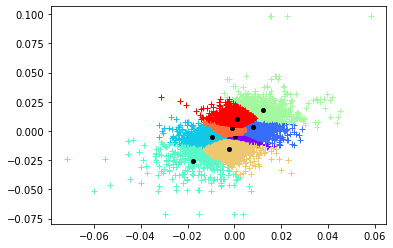

In [73]:
colors = cm.rainbow(np.linspace(0, 1, nb_clusters))

for i, c in enumerate(colors):
    d = X_Kmeans_With_Label[X_Kmeans_With_Label["Labels"] == i][["x_axis", "y_axis"]]
    d = d.set_index(d.columns[0])
    plt.plot(d.index, d.values, color=c, linestyle="", marker="+")
    plt.plot(kmeans.cluster_centers_[i][0], kmeans.cluster_centers_[i][1], color="black",  linestyle="", marker="o", 
             markersize=4)
    
plt.show()

### Affinity Propagation

In [80]:
from sklearn.cluster import AffinityPropagation

In [81]:
X = data[["SGIXTFEQ Index", "SGIXTFCY Index", "SGIXTFFX Index", "SGIXTFIR Index", "NEIXCTAT Index"]]
X_returns = X/X.shift(1) - 1

In [97]:
X_AffProp = pd.DataFrame(columns=["x_axis", "y_axis"])

for col in ["SGIXTFEQ Index", "SGIXTFCY Index", "SGIXTFFX Index", "SGIXTFIR Index"]:
    X_AffProp = pd.concat([X_AffProp, X_returns[[col, "NEIXCTAT Index"]].
                          rename(columns={col: "x_axis", "NEIXCTAT Index": "y_axis"})], ignore_index=True)

X_AffProp = X_AffProp.dropna()
X_AffProp = X_AffProp.iloc[:600]

In [98]:
X_AffProp

,x_axis,y_axis
1,-0.020884,-0.008799
2,0.017615,-0.018811
3,0.015081,0.031984
4,-0.006809,0.005500
5,0.006325,-0.002500
...,...,...
596,-0.018154,-0.015600
597,-0.024684,-0.019241
598,0.006193,-0.007200
599,-0.010492,-0.014800


In [99]:
affinity_propagation = AffinityPropagation(random_state=5).fit(X_AffProp.values)

In [100]:
labels =  pd.DataFrame(columns=["Labels"], data=affinity_propagation.labels_, index=X_AffProp.index)
X_AffProp_With_Label = pd.concat([X_AffProp, labels], axis=1)
X_AffProp_With_Label

,x_axis,y_axis,Labels
1,-0.020884,-0.008799,6
2,0.017615,-0.018811,9
3,0.015081,0.031984,24
4,-0.006809,0.005500,29
5,0.006325,-0.002500,21
...,...,...,...
596,-0.018154,-0.015600,23
597,-0.024684,-0.019241,23
598,0.006193,-0.007200,0
599,-0.010492,-0.014800,2


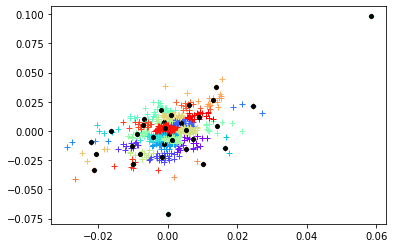

In [101]:
colors = cm.rainbow(np.linspace(0, 1, len(affinity_propagation.cluster_centers_)))

for i, c in enumerate(colors):
    d = X_AffProp_With_Label[X_AffProp_With_Label["Labels"] == i][["x_axis", "y_axis"]]
    d = d.set_index(d.columns[0])
    plt.plot(d.index, d.values, color=c, linestyle="", marker="+")
    plt.plot(affinity_propagation.cluster_centers_[i][0], affinity_propagation.cluster_centers_[i][1], color="black",  
             linestyle="", marker="o", markersize=4)
plt.show()